In [1]:
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import warnings
import os
from datetime import datetime
from src import train_neural_net
from scipy import stats
import torch

warnings.filterwarnings("ignore")

### Parameters

In [2]:
metrics_filename="metrics.csv"
models={}
metrics_model={}

## Grid search with Cross validation

### Loading Data

In [3]:
train_data=pd.read_csv("data/train_prep.csv")
test_data=pd.read_csv("data/test_prep.csv")
#Check if metrics file exists
if os.path.isfile('./'+metrics_filename):
    metrics=pd.read_csv(metrics_filename)
else:
    metrics=pd.DataFrame(columns=["date","model","params","best_train_score","RMSE","MSE","MAE"])

### Training Data

Training model of type:

Sequential(
  (0): Linear(in_features=4, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.023651203	0.0008673609
		2000	0.017053546	9.315882e-05
		3000	0.016313246	2.2492939e-05
		4000	0.016010514	1.8381204e-05
		5000	0.015770618	1.1928823e-05
		Final loss:
		5829	0.015638057	5.9554844e-07

	Best loss: 0.01563805714249611


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.026484046	0.00078834937
		2000	0.018155985	0.00012401743
		3000	0.016923953	4.1380736e-05
		4000	0.016443446	2.1521946e-05
		5000	0.016114788	1.722203e-05
		Final loss:
		5466	0.016016472	6.977731e-07

	Best loss: 0.01601647213101387


Crossvalidation fold: 3/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.025207572	0.00057492073
		2000	0.018500784	0.00013287895
		3000	0.017147528	4.86615e-05
		4000	0.016597185	2.31181

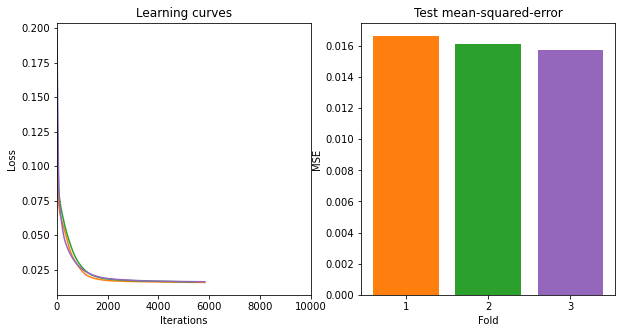

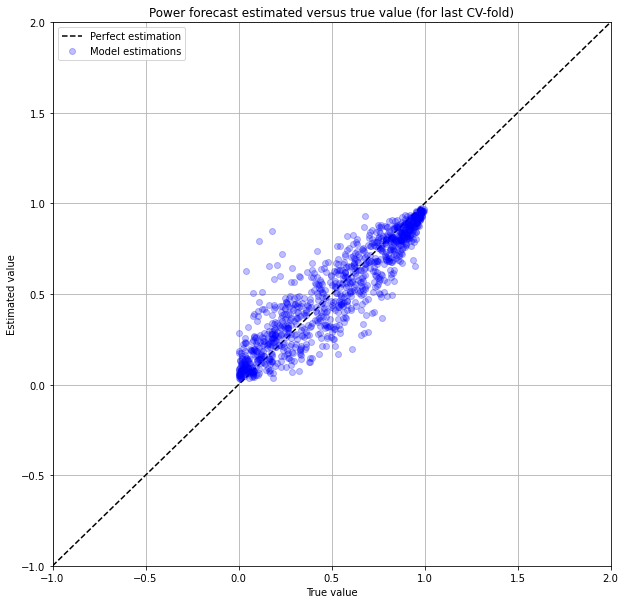

In [4]:
X = train_data[['U10','U100','V10','V100','POWER']]
          
X=np.array(X)
attributeNames=['U10','U100','V10','V100']

y=X[:,[4]] 
X=X[:,0:4]
N, M = X.shape
#C = 2


                
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0);
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,0:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 15      # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000        # 

# K-fold crossvalidation
K = 3                   
CV = KFold(K, shuffle=True)


summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))

color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']
# Define the model
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1),# n_hidden_units to 1 output neuron
                    torch.nn.Sigmoid() #2nd tranfer function
                   
                    )
loss_fn = torch.nn.MSELoss() 

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.float)
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       n_epochs=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_test_est = net(X_test)
    
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    errors.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE');
summaries_axes[1].set_title('Test mean-squared-error')   
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]


# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))


plt.figure(figsize=(10,10));
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy();
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true[0:1000], y_est[0:1000],'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Power forecast estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()
plt.show()